/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 913ms/step - loss: 0.1851 - mean_absolute_error: 0.1808 - val_loss: 0.1415 - val_mean_absolute_error: 0.1205
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 893ms/step - loss: 0.1386 - mean_absolute_error: 0.1190 - val_loss: 0.1231 - val_mean_absolute_error: 0.1082
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 885ms/step - loss: 0.1204 - mean_absolute_error: 0.1082 - val_loss: 0.1081 - val_mean_absolute_error: 0.0942
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 737ms/step - loss: 0.1053 - mean_absolute_error: 0.0941 - val_loss: 0.0947 - val_mean_absolute_error: 0.0805
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 852ms/step - loss: 0.0919 - mean_absolute_error: 0.0777 - val_loss: 0.0840 - val_mean_absolute_error: 0.0700
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 874ms/step - loss: 0.0809 - mean_absolute_error: 0.0658 - val_loss: 0.0757 - val_mean_absolute_error: 0.0671
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 754ms/step - loss: 0.0732 - mean_absolute_error: 0.0

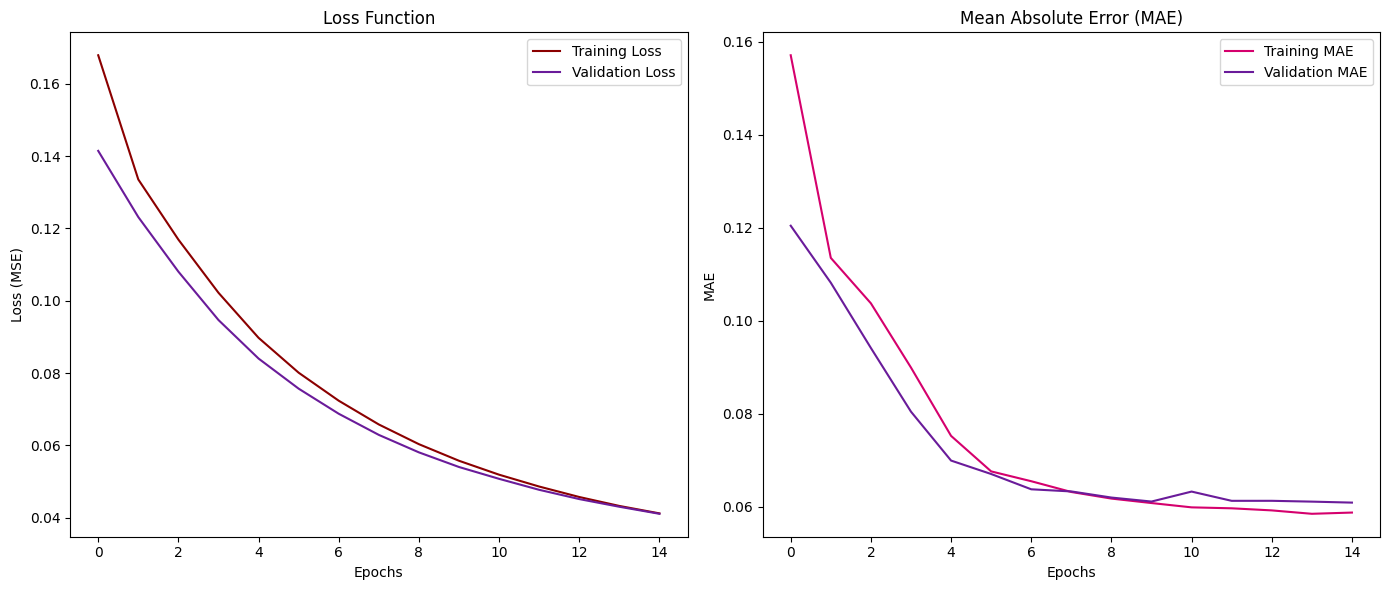

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


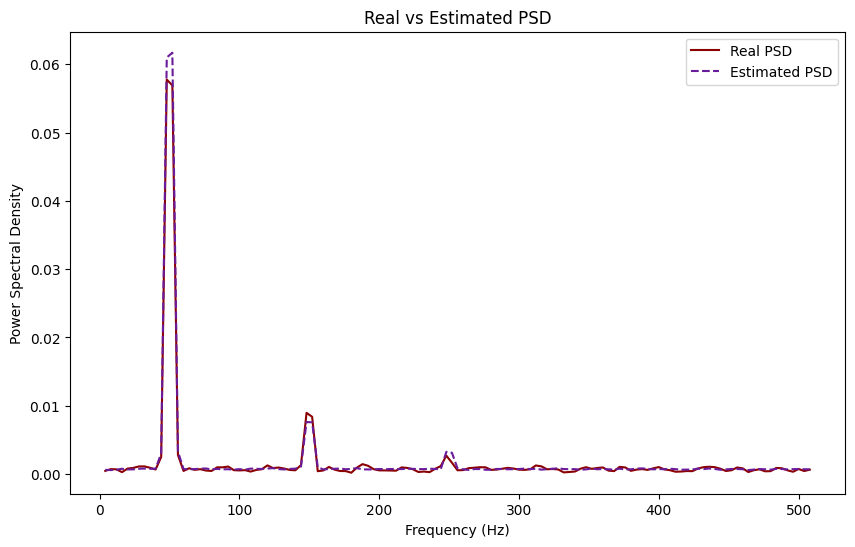

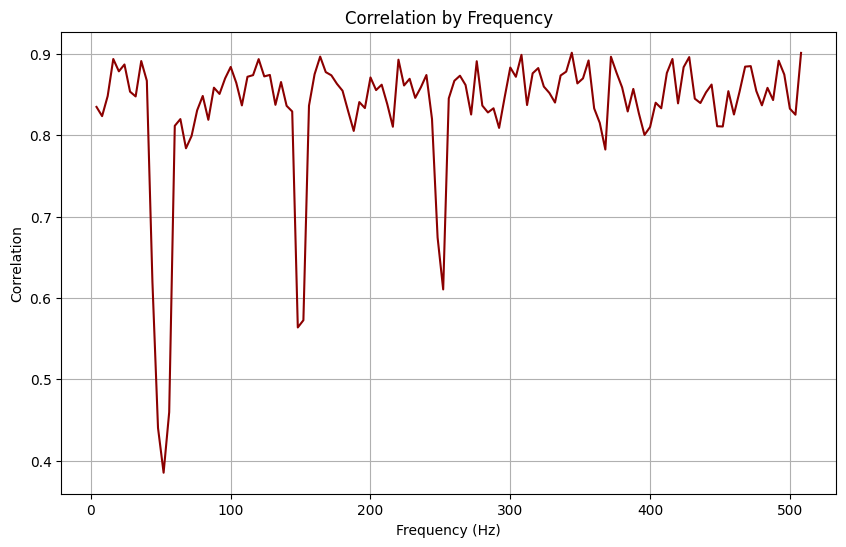

Average correlation between real and estimated PSD: 0.8339


In [1]:
import numpy as np
from scipy.signal import welch
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing
from sklearn.preprocessing import MinMaxScaler  # To scale the data to a specific range (e.g., [0, 1])
import matplotlib.pyplot as plt  # For creating visual plots
import tensorflow as tf  # Importing TensorFlow for neural network building
from tensorflow.keras.models import Sequential  # To create a sequential model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LeakyReLU  # Layers for the CNN model
from tensorflow.keras.regularizers import l2  # Regularizer to prevent overfitting by penalizing large weights
from tensorflow.keras.callbacks import EarlyStopping  # For stopping the training early if the model's performance doesn't improve
from scipy.stats import pearsonr  # To compute Pearson correlation for model evaluation

# 1. Signal Generation Class
class SignalGenerator:
    def __init__(self, sampling_frequency=1024, signal_duration=1, noise_mean=0, base_freq=50, num_samples=512):
        """
        This class generates synthetic signals with noise and calculates their PSD using the Welch method.
        """
        # Define the signal's properties: sampling frequency, duration, base frequency, etc.
        self.sampling_frequency = sampling_frequency
        self.signal_duration = signal_duration
        self.noise_mean = noise_mean
        self.base_freq = base_freq
        self.num_samples = num_samples
        # Create time vector t from 0 to signal_duration, spaced by the inverse of the sampling frequency
        self.t = np.arange(0, self.signal_duration, 1 / self.sampling_frequency)
        # Define the original signal as a sum of cosines and sines with different frequencies
        self.x_original = np.cos(2 * np.pi * self.base_freq * self.t) - (1 / 3) * np.sin(3 * 2 * np.pi * self.base_freq * self.t) + (1 / 5) * np.cos(5 * 2 * np.pi * self.base_freq * self.t)

    def generate_data(self):
        """
        Generates noisy signals and computes their Power Spectral Density (PSD).
        """
        signals = []
        psd_targets = []
        # Generate 'num_samples' noisy signals by adding Gaussian noise to the original signal
        for _ in range(self.num_samples):
            noise_std = np.random.uniform(0.1, 1.0)  # Random noise standard deviation
            noise = np.random.normal(self.noise_mean, noise_std, self.t.shape)  # Generate Gaussian noise
            noisy_signal = self.x_original + noise  # Add noise to the original signal
            # Calculate the PSD of the noisy signal using the Welch method
            frequencies, psd = welch(noisy_signal, fs=self.sampling_frequency, nperseg=256)
            signals.append(noisy_signal)
            psd_targets.append(psd[1:-1])  # Exclude the DC and Nyquist components (not used in the PSD model)

        # Convert lists to numpy arrays
        signals = np.array(signals)
        psd_targets = np.array(psd_targets)
        frequencies = frequencies[1:-1]  # Adjust frequencies to match the PSD array
        return signals, psd_targets, frequencies


# 2. Data Preprocessing Class
class DataPreprocessor:
    def __init__(self):
        """
        This class handles data preprocessing, such as scaling signals and splitting data into train and test sets.
        """
        self.scaler = MinMaxScaler()  # Initialize the MinMaxScaler to scale PSD values

    def normalize_signals(self, signals):
        """
        Normalizes the signals to have values between -1 and 1 by dividing by the global max value.
        """
        global_max = np.max(np.abs(signals))  # Find the maximum absolute value of the signals
        return signals / global_max  # Normalize the signals by dividing by the global max

    def normalize_psd(self, psd_targets):
        """
        Scales the PSD values to the range [0, 1] using MinMaxScaler.
        """
        return self.scaler.fit_transform(psd_targets)

    def split_data(self, signals, psd_targets):
        """
        Splits the data into training and testing sets, with 80% for training and 20% for testing.
        Reshapes the data for compatibility with Conv1D layers in the neural network.
        """
        X_train, X_test, y_train, y_test = train_test_split(signals, psd_targets, test_size=0.2, random_state=42)
        X_train = X_train[..., np.newaxis]  # Add an extra axis to match Conv1D input shape
        X_test = X_test[..., np.newaxis]  # Do the same for the test data
        return X_train, X_test, y_train, y_test


# 3. Neural Network Class
class PsdPredictionModel:
    def __init__(self, input_shape, output_shape):
        """
        This class defines, compiles, trains, and evaluates a deep learning model for PSD prediction.
        """
        self.model = self.build_model(input_shape, output_shape)  # Build the model

    def build_model(self, input_shape, output_shape):
        """
        Builds the convolutional neural network (CNN) model.
        """
        model = Sequential([
            Conv1D(64, kernel_size=5, activation='linear', input_shape=input_shape),  # First convolutional layer
            LeakyReLU(alpha=0.1),  # Leaky ReLU activation function
            MaxPooling1D(pool_size=2),  # Max pooling layer to reduce dimensionality
            Conv1D(128, kernel_size=5, activation='linear', kernel_regularizer=l2(1e-4)),  # Second convolutional layer with L2 regularization
            LeakyReLU(alpha=0.1),
            MaxPooling1D(pool_size=2),
            Conv1D(256, kernel_size=5, activation='linear', kernel_regularizer=l2(1e-4)),  # Third convolutional layer with L2 regularization
            LeakyReLU(alpha=0.1),
            MaxPooling1D(pool_size=2),
            Flatten(),  # Flatten the output for the fully connected layers
            Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),  # Fully connected layer
            Dense(output_shape, activation='linear')  # Output layer with linear activation for regression
        ])
        return model

    def compile(self):
        """
        Compiles the model with Adam optimizer, MSE loss, and MAE metrics.
        """
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                           loss='mean_squared_error', metrics=['mean_absolute_error'])

    def train(self, X_train, y_train, X_val, y_val):
        """
        Trains the model using early stopping to prevent overfitting.
        """
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = self.model.fit(X_train, y_train, epochs=15, batch_size=32,
                                 validation_data=(X_val, y_val), callbacks=[early_stopping])
        return history

    def evaluate(self, X_test, y_test):
        """
        Evaluates the trained model on the test set.
        """
        test_loss, test_mae = self.model.evaluate(X_test, y_test)
        return test_loss, test_mae

    def predict(self, X_test):
        """
        Makes predictions on the test data using the trained model.
        """
        return self.model.predict(X_test)


# 4. Plotting Utility Class
class Plotter:
    """
    This class contains methods for plotting training progress and results.
    """
    @staticmethod
    def plot_loss(history):
        """
        Plots the training and validation loss during training.
        """
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss', color='#8B0000')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='#6A1B9A')
        plt.title('Loss Function')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (MSE)')
        plt.legend()

    @staticmethod
    def plot_mae(history):
        """
        Plots the training and validation Mean Absolute Error (MAE) during training.
        """
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mean_absolute_error'], label='Training MAE', color='#D5006D')
        plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE', color='#6A1B9A')
        plt.title('Mean Absolute Error (MAE)')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_psd(frequencies, y_real, y_pred):
        """
        Plots the real vs. predicted PSD for a random test sample.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(frequencies, y_real, label='Real PSD', color='#8B0000')
        plt.plot(frequencies, y_pred, label='Estimated PSD', color='#6A1B9A', linestyle='--')
        plt.title('Real vs Estimated PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density')
        plt.legend()
        plt.show()

    @staticmethod
    def plot_correlation(frequencies, correlations):
        """
        Plots the Pearson correlation between real and predicted PSD values for each frequency.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(frequencies, correlations, color='#8B0000')
        plt.title("Correlation by Frequency")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Correlation")
        plt.grid()
        plt.show()


# Main Execution
if __name__ == "__main__":
    # Initialize the signal generator, data preprocessor, and model
    signal_generator = SignalGenerator()
    signals, psd_targets, frequencies = signal_generator.generate_data()

    data_preprocessor = DataPreprocessor()
    signals_normalized = data_preprocessor.normalize_signals(signals)
    psd_targets_normalized = data_preprocessor.normalize_psd(psd_targets)
    X_train, X_test, y_train, y_test = data_preprocessor.split_data(signals_normalized, psd_targets_normalized)

    # Build and compile the model
    model = PsdPredictionModel(input_shape=(signals.shape[1], 1), output_shape=psd_targets.shape[1])
    model.compile()

    # Train the model
    history = model.train(X_train, y_train, X_test, y_test)

    # Evaluate the model on the test set
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    # Plot training loss and MAE
    Plotter.plot_loss(history)
    Plotter.plot_mae(history)

    # Make predictions and plot results for a random test sample
    y_pred = model.predict(X_test)
    y_pred = data_preprocessor.scaler.inverse_transform(y_pred)
    y_test_actual = data_preprocessor.scaler.inverse_transform(y_test)

    index = np.random.randint(0, X_test.shape[0])  # Select a random index from the test set
    Plotter.plot_psd(frequencies, y_test_actual[index], y_pred[index])

    # Calculate and plot Pearson correlation for each frequency
    correlations = [pearsonr(y_test_actual[:, i], y_pred[:, i])[0] for i in range(y_test_actual.shape[1])]
    Plotter.plot_correlation(frequencies, correlations)

    # Print the average correlation between the real and predicted PSD values
    print(f"Average correlation between real and estimated PSD: {np.mean(correlations):.4f}")
